## using statement

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import textstat


## Constant

In [9]:
RANDOM_STATE=42
C=0.01
MAX_ITER=500

## Read data from file

In [10]:
def read_data(path_fake,path_true):
    df_fake=pd.read_csv(path_fake)
    df_true=pd.read_csv(path_true)
    df_fake["label"]="fake"
    df_true["label"]="true"
    df_fake["target"]=0
    df_true["target"]=1

    df=pd.concat([df_fake,df_true],ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

In [11]:
df=read_data("Fake.csv","True.csv")

## Clean data

### basic feature from text

In [12]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()                              # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)               # remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)             # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra whitespace
    return text

In [13]:
def avg_word_length_long_words(text):
    words = text.split()
    long_words = [w for w in words if len(w) >= 4]
    if not long_words:  # avoid division by zero
        return 0
    return sum(len(w) for w in long_words) / len(long_words)

In [14]:
def num_unique_words(text):
    return len(set(text.split()))

In [15]:
def avg_word_length(text):
    words = text.split()
    return np.mean([len(w) for w in words]) if words else 0

In [16]:
def punctuation_count(text):
    return len(re.findall(r'[^\w\s]', text))

In [17]:
def exclamation_count(text):
    return text.count('!')

In [18]:
def question_count(text):
    return text.count('?')

In [19]:
def num_uppercase_words(text):
    return sum(1 for w in text.split() if w.isupper())

In [20]:
def title_word_overlap_ratio(text, title):
    if not title:
        return 0
    title_words = set(title.lower().split())
    text_words = set(text.lower().split())
    if len(title_words) == 0:
        return 0
    return len(title_words & text_words) / len(title_words)

In [21]:
def contains_hyperlink(text):
    return int('http' in text or 'www' in text)

In [22]:
def avg_sentences_length(text):
    # Split by '.', filter out empty sentences
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    sentences_length = [len(s.split()) for s in sentences]
    return np.mean(sentences_length)

In [23]:
def num_word(text):
    return len(text.split())

In [24]:
def num_sentences(text):
    # Split on ., !, ? followed by a space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

In [25]:
def vocabulary_richness(text):
    words=[word for word in text.split()]
    if(len(words)==0):
        return 0
    res=len(set(words)) / len(words)
    return res

In [26]:
def most_used_word_count(text):
    words = re.findall(r'\b\w+\b', text.lower())
    if not words:
        return 0
    word_counts = Counter(words)
    return word_counts.most_common(1)[0][1]  # just the count

### language processing features

In [27]:
def readablitity(text):
    score=textstat.flesch_reading_ease(text)
    return score

In [28]:
def smog_index(text):
    index=textstat.smog_index(text)
    return index

In [29]:
def difficalt_word(text):
    difficality=textstat.difficult_words(text)
    return difficality

In [ ]:
def extract_features(text, title):
    return {
        'num_unique_words': num_unique_words(text),
        
        'punctuation_count': punctuation_count(text),
        'exclamation_count': exclamation_count(text),
        'question_count': question_count(text),
        
        'title_word_overlap_ratio': title_word_overlap_ratio(text, title),
        'contains_hyperlink': contains_hyperlink(text),
        
        
        
        
        'vocabulary_richness': vocabulary_richness(text),
        
        'readablility_text':readablitity(text),
        'smog':smog_index(text),
        'difficalt_word':difficalt_word(text)
    }


In [31]:
def clean_data(df):
    df["length_text"] = df["text"].apply(len)
    df["length_title"] = df["title"].apply(len)

    df['text_title_length_relation'] = df.apply(
        lambda row: row['length_text'] / row['length_title'] if row['length_title'] != 0 else 0, axis=1
    )

    features_df = df.apply(lambda row: extract_features(row['text'], row['title']), axis=1, result_type='expand')

    df = pd.concat([df, features_df], axis=1)
    df = df.drop(columns=['title', 'text', 'subject', 'date', 'label'])
    df = df.dropna()
    return df


In [32]:
clean_df=clean_data(df)
clean_df.head()
clean_df.describe()
clean_df.to_csv('/home/abolfazl/Documents/python-code/FakeNewsDetection/data/clean_data.csv',index=False)


In [33]:
clean_df.head()
clean_df.to_csv('/home/abolfazl/Documents/python-code/FakeNewsDetection/data/clean_data.csv',index=False)

## scatter the text and title length

In [34]:
def scatter_title_text_lenght(df):
    df_0 = df[df['target'] == 0]
    plt.scatter(df_0['length_text'], df_0['length_title'], color='red', label='Target 0')

    # Plot points where target == 1 (green)
    df_1 = df[df['target'] == 1]
    plt.scatter(df_1['length_text'], df_1['length_title'], color='green', label='Target 1')

    # Add labels and legend
    plt.xlabel('Length of Text')
    plt.ylabel('Length of Title')
    plt.title('Text vs Title Length by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_4plus'], df_0['text_title_length_relation'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_4plus'], df_1['text_title_length_relation'], color='green', label='Target 1')
    plt.xlabel('avg_len_4plus')
    plt.ylabel('text_title_length_relation')
    plt.title('text_title_length_relation vs avg_len_4plus  by Target')
    plt.legend()

    # Show plot
    plt.show()


    plt.scatter(df_0['avg_len_sentences'], df_0['number_word'], color='red', label='Target 0')
    plt.scatter(df_1['avg_len_sentences'], df_1['number_word'], color='green', label='Target 1')
    plt.xlabel('avg_len_sentences')
    plt.ylabel('number_word')
    plt.title('number_word vs avg_len_sentences  by Target')
    plt.legend()

    # Show plot
    plt.show()

    
    plt.scatter(df_0['vocabulary_richness'], df_0['num_sentences'], color='red', label='Target 0')
    plt.scatter(df_1['vocabulary_richness'], df_1['num_sentences'], color='green', label='Target 1')
    plt.xlabel('vocabulary_richness')
    plt.ylabel('num_sentences')
    plt.title('num_sentences vs vocabulary_richness  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['avg_word_length'], df_0['num_unique_words'], color='red', label='Target 0')
    plt.scatter(df_1['avg_word_length'], df_1['num_unique_words'], color='green', label='Target 1')
    plt.xlabel('avg_word_length')
    plt.ylabel('num_unique_words')
    plt.title('num_unique_words vs vocabulavg_word_lengthary_richness  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['exclamation_count'], df_0['punctuation_count'], color='red', label='Target 0')
    plt.scatter(df_1['exclamation_count'], df_1['punctuation_count'], color='green', label='Target 1')
    plt.xlabel('exclamation_count')
    plt.ylabel('punctuation_count')
    plt.title('punctuation_count vs exclamation_count  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['num_uppercase_words'], df_0['question_count'], color='red', label='Target 0')
    plt.scatter(df_1['num_uppercase_words'], df_1['question_count'], color='green', label='Target 1')
    plt.xlabel('num_uppercase_words')
    plt.ylabel('question_count')
    plt.title('question_count vs num_uppercase_words  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['contains_hyperlink'], df_0['title_word_overlap_ratio'], color='red', label='Target 0')
    plt.scatter(df_1['contains_hyperlink'], df_1['title_word_overlap_ratio'], color='green', label='Target 1')
    plt.xlabel('contains_hyperlink')
    plt.ylabel('title_word_overlap_ratio')
    plt.title('title_word_overlap_ratio vs contains_hyperlink  by Target')
    plt.legend()

    # Show plot
    plt.show()

    plt.scatter(df_0['readablility_text'], df_0['smog'], color='red', label='Target 0')
    plt.scatter(df_1['readablility_text'], df_1['smog'], color='green', label='Target 1')
    plt.xlabel('readablility_text')
    plt.ylabel('smog')
    plt.title('smog vs readablility_text  by Target')
    plt.legend()

    # Show plot
    plt.show()

    
    plt.scatter(df_0['difficalt_word'], df_0['smog'], color='red', label='Target 0')
    plt.scatter(df_1['difficalt_word'], df_1['smog'], color='green', label='Target 1')
    plt.xlabel('difficalt_word')
    plt.ylabel('smog')
    plt.title('smog vs difficalt_word  by Target')
    plt.legend()

    # Show plot
    plt.show()


    
    
    

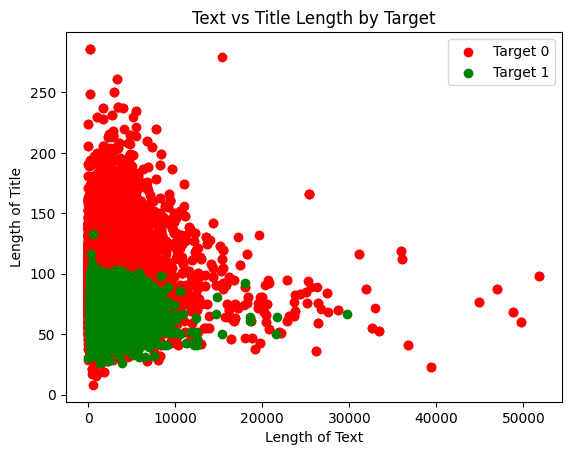

KeyError: 'avg_len_4plus'

In [ ]:
#scatter_title_text_lenght(clean_df)

## seperate the X and Y

In [36]:
x_df=clean_df.drop(columns=['target'])
y_df=clean_df["target"]

## split the train test

In [37]:
def split_train_test_valid(x_df,y_df,test_size,valid_size):
    x_train,x_test,y_train,y_test=train_test_split(x_df,y_df,test_size=test_size,random_state=RANDOM_STATE)
    x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=valid_size,random_state=RANDOM_STATE)
    return x_train,x_test,x_valid,y_train,y_test,y_valid

In [38]:
x_train,x_test,x_valid,y_train,y_test,y_valid=split_train_test_valid(x_df,y_df,test_size=0.2,valid_size=0.25)

## hyper parameter tuning

In [39]:


def manual_grid_search_linear(x_train, y_train, x_valid, y_valid, param_grid):
    best_model = None
    best_score = 0
    best_params = {}

    for C in param_grid['C']:
        for max_iter in param_grid.get('max_iter', [1000]):
            model = LinearSVC(C=C, max_iter=max_iter)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_valid)
            score = accuracy_score(y_valid, y_pred)

            if score > best_score:
                best_score = score
                best_model = model
                best_params = {'C': C, 'max_iter': max_iter}

    return best_model, best_params, best_score


In [40]:
# param_grid = {
#     'C': [0.001,0.01, 0.1, 1, 10,100],
#     'max_iter': [100,200,500,1000]
# }

# best_model, best_params, best_score = manual_grid_search_linear(x_train, y_train, x_valid, y_valid, param_grid)
# print(f"best model: {best_model}")
# print(f"best parameter: {best_params}")
# print(f"best score{best_score}")


In [41]:
svc_model=LinearSVC(C=C,max_iter=MAX_ITER)
svc_model.fit(x_train,y_train)
y_pred_train=svc_model.predict(x_train)
y_pred_test=svc_model.predict(x_test)

train_accuracy=accuracy_score(y_pred_train,y_train)
test_accuracy=accuracy_score(y_pred_test,y_test)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

train accuracy: 0.9066745860865691
test accuracy: 0.9062360801781737


In [42]:
lr_model=LogisticRegression(max_iter=MAX_ITER)
lr_model.fit(x_train,y_train)
y_pred_train_logistic=lr_model.predict(x_train)
y_pred_test_logistic=lr_model.predict(x_test)

train_accuracy=accuracy_score(y_pred_train_logistic,y_train)
test_accuracy=accuracy_score(y_pred_test_logistic,y_test)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")

train accuracy: 0.8960947360605835
test accuracy: 0.8979955456570156


/home/abolfazl/Documents/citizen_journal/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
class News:
    def __init__(self,title,text):
        self.title=title
        self.text=text
    

In [44]:
def predict_one(news:News,svm_model,logistic_model):
    news_list=[[news.title,news.text,"'subject","date",'abel']]
    news_dataframe=pd.DataFrame(news_list,columns=['text','title','subject','date','label'])
    news_dataframe=clean_data(news_dataframe)
    svm_label=svm_model.predict(news_dataframe)
    logistic_label=logistic_model.predict(news_dataframe)
    return {
        "svm label":svm_label[0],
        "logistic regression label":logistic_label[0]
    }




In [45]:
#predict_one(News("this is title","and this is the text"),svc_model,lr_model)

In [46]:
# title=input("Enter title: ")
# text=input("Enter text:")
# predict_one(News(title,text),best_model,model)

In [47]:
import joblib

def save_model(models:list):

    for model in models:
        joblib.dump(model,f'{str(model)}.pkl')
        print(f"model {str(model)} has been saved")

In [ ]:
#save_model([svc_model,lr_model])

model LinearSVC(C=0.01, max_iter=500) has been saved
model LogisticRegression(max_iter=500) has been saved
